# Case study with linear models (10pts)
# Motivation
Modeling the sale price of a home could be valuable for multiple reasons: 
- To a real estate investor, understanding the future value of a property can guide purchasing strategies. 
- To a home buyer, a model could help inform them which house, in a set of potential purchases, is reasonably priced. 
- From the perspective of a governing entity, understanding the determinants of sales price can inform policy that seeks to create affordable housing or highlight and respond to volatility in housing markets.

# Overview
In this assignment, we will apply linear regression, polynomial regression, and
regularization techniques to predict the sale price of houses. The [dataset](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/data) we use contains a rich set of features: 79 explanatory variables describing various  aspects of residential homes in Ames, Iowa.


# Goals

1) Predict the sales price of a home using a real-world dataset

2) Use regularization to avoid overfitting and improve model performance 

3) Explain how machine learning help us better understand variation in housing prices


In [127]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# Exploratory Data Analysis (EDA)

In [128]:
# Import data and check basic information
# Note: please use the dataset we provided on Canvas, do not use the one posted on Kaggle
df = pd.read_csv('./house_data.csv')
df.shape

(2919, 81)

In [129]:
# View variables
df.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [130]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0


## Explore target variable

The variable: SalePrice - the property's sale price in dollars

The aim here is to better understand our target and verify its integrity. We will look at some summary statistics, empirical distribution and missing values.

In [131]:
print(df.SalePrice.describe()) # Look at summary statistics
print()
print("Number of missing values: {}".format(df.SalePrice.isna().sum())) 
print("Proportion of missing values: {:.4f}".format(df.SalePrice.isna().sum()/len(df)))

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

Number of missing values: 1459
Proportion of missing values: 0.4998


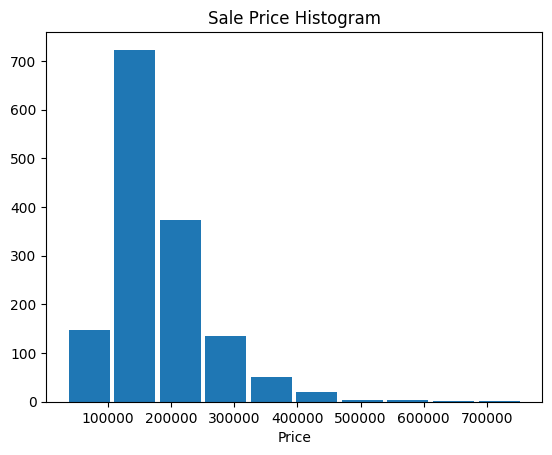

In [132]:
# Visualize the distribution
plt.hist(df.SalePrice, rwidth=0.9)
plt.xlabel('Price')
plt.title('Sale Price Histogram');

We gain some helpful informatino from all of this:
- First, we see that there are a significant amount of missing values -- we need to deal with these.
- Furthermore, we see that there are outliers on the upper end of the distribution, i.e., some houses are sold for extremely high prices.

Shape of data before dropping: (2919, 81)
Shape of data after dropping: (1460, 81)



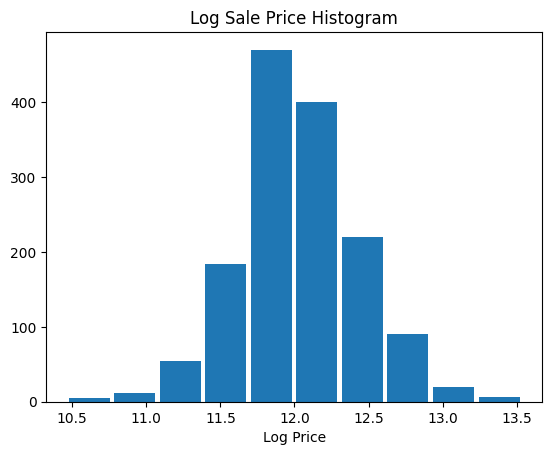

In [133]:
# Drop missing values
print('Shape of data before dropping: {}'.format(df.shape))
df_clean = df.drop(df[df['SalePrice'].isna()].index, axis=0)
print('Shape of data after dropping: {}'.format(df_clean.shape))
print()

# Data transformation: take log of the target variable, to reduce the range of the prices
df_clean['lg_SalePrice'] = np.log(df['SalePrice'])

# Visualize the transformed distribution
plt.hist(df_clean.lg_SalePrice, rwidth=0.9)
plt.xlabel('Log Price')
plt.title('Log Sale Price Histogram');

## Explore feature variables

We will now apply a similar approach to explore our features:

1) Check for and deal with missing values

2) Determine feature types

3) Clean features based on their type



## Missing values

In [134]:
# Check missing values
null_perct = df_clean.isna().sum()/len(df_clean)
null_perct[null_perct>0]

LotFrontage     0.177397
Alley           0.937671
MasVnrType      0.597260
MasVnrArea      0.005479
BsmtQual        0.025342
BsmtCond        0.025342
BsmtExposure    0.026027
BsmtFinType1    0.025342
BsmtFinType2    0.026027
Electrical      0.000685
FireplaceQu     0.472603
GarageType      0.055479
GarageYrBlt     0.055479
GarageFinish    0.055479
GarageQual      0.055479
GarageCond      0.055479
PoolQC          0.995205
Fence           0.807534
MiscFeature     0.963014
dtype: float64

In [135]:
# Note that some features have a large portion of missing observations (e.g., PoolQC).
# In response, we will drop columns that have more than 30% missing values.
# Recall that there are other potential ways to deal with missing values, such as imputation, but this is not the focus of this assignment.

print(df_clean.shape)
df_clean = df_clean.drop(columns=df_clean.columns[null_perct > 0.3])
print(df_clean.shape)

# feature size reduced from 82 to 77

(1460, 82)
(1460, 76)


In [136]:
# Next, we will drop samples with any remaining missing values.
print(df_clean.shape)
df_final = df_clean.dropna().reset_index(drop=True)
print(df_final.shape)

# sample size reduced from 1460 to 1094

(1460, 76)
(1094, 76)


## Explore feature types

What kind of feature types do we have? Organize features into types.

### Begin with numeric variables

In [137]:
# Identify numeric types
df_final.select_dtypes(['int', 'float']).dtypes

Id                 int64
MSSubClass         int64
LotFrontage      float64
LotArea            int64
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
MasVnrArea       float64
BsmtFinSF1       float64
BsmtFinSF2       float64
BsmtUnfSF        float64
TotalBsmtSF      float64
1stFlrSF           int64
2ndFlrSF           int64
LowQualFinSF       int64
GrLivArea          int64
BsmtFullBath     float64
BsmtHalfBath     float64
FullBath           int64
HalfBath           int64
BedroomAbvGr       int64
KitchenAbvGr       int64
TotRmsAbvGrd       int64
Fireplaces         int64
GarageYrBlt      float64
GarageCars       float64
GarageArea       float64
WoodDeckSF         int64
OpenPorchSF        int64
EnclosedPorch      int64
3SsnPorch          int64
ScreenPorch        int64
PoolArea           int64
MiscVal            int64
MoSold             int64
YrSold             int64
SalePrice        float64
lg_SalePrice     float64
dtype: object

In [138]:
# Generate descriptive statistics for numeric variables
df_final.select_dtypes(['int', 'float']).describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,lg_SalePrice
count,1094.000000,1094.000000,1094.000000,1094.000000,1094.000000,1094.000000,1094.000000,1094.000000,1094.000000,1094.000000,...,1094.000000,1094.000000,1094.000000,1094.000000,1094.000000,1094.000000,1094.000000,1094.000000,1094.000000,1094.000000
mean,727.375686,56.128885,70.759598,10132.346435,6.247715,5.575868,1972.412249,1985.915905,109.855576,448.191956,...,46.946984,22.053016,3.266910,16.498172,3.007313,23.550274,6.335466,2007.786106,187033.263254,12.057513
std,420.955488,41.976345,24.508859,8212.249621,1.366797,1.066500,31.189752,20.930772,190.667459,468.728095,...,64.820019,61.570502,29.655973,58.455303,40.713175,167.135237,2.694558,1.334307,83165.332151,0.394847
min,1.000000,20.000000,21.000000,1300.000000,2.000000,2.000000,1880.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,35311.000000,10.471950
25%,366.500000,20.000000,60.000000,7606.750000,5.000000,5.000000,1953.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,132500.000000,11.794338
50%,723.500000,50.000000,70.000000,9444.500000,6.000000,5.000000,1975.000000,1995.000000,0.000000,384.500000,...,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,165750.000000,12.018235
75%,1093.750000,70.000000,80.000000,11387.250000,7.000000,6.000000,2003.000000,2005.000000,171.750000,712.750000,...,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,221000.000000,12.305918
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,547.000000,552.000000,508.000000,480.000000,648.000000,2500.000000,12.000000,2010.000000,755000.000000,13.534473


Note that we have both integer (e.g., YearBuilt, YrSold) and float (e.g., LotFrontage) variables.

While there are some integers such as MSSubClas, that one may want to treat differently, perhaps by one-hot encoding, here we will let them enter the regression as integer features.

In [139]:
# Collect numeric features to be included in later analysis
all_num_cols = df_final.select_dtypes(['int', 'float']).columns
num_cols = all_num_cols[1:len(all_num_cols)-2] # Collect numeric features, exclude ID and target variable
df_num = df_final[num_cols] # Exclude ID and target variable
print(df_num.shape)

(1094, 36)


### Check text/string variables 

In [140]:
# Pandas strings
df_final.select_dtypes(['object']).dtypes

MSZoning         object
Street           object
LotShape         object
LandContour      object
Utilities        object
LotConfig        object
LandSlope        object
Neighborhood     object
Condition1       object
Condition2       object
BldgType         object
HouseStyle       object
RoofStyle        object
RoofMatl         object
Exterior1st      object
Exterior2nd      object
ExterQual        object
ExterCond        object
Foundation       object
BsmtQual         object
BsmtCond         object
BsmtExposure     object
BsmtFinType1     object
BsmtFinType2     object
Heating          object
HeatingQC        object
CentralAir       object
Electrical       object
KitchenQual      object
Functional       object
GarageType       object
GarageFinish     object
GarageQual       object
GarageCond       object
PavedDrive       object
SaleType         object
SaleCondition    object
dtype: object

In [141]:
# Tabulate variables to better understand their content
for col in df_final.select_dtypes(['object']).columns:
    print(df_final[col].value_counts(),'\n') 

MSZoning
RL         850
RM         173
FV          54
RH           9
C (all)      8
Name: count, dtype: int64 

Street
Pave    1090
Grvl       4
Name: count, dtype: int64 

LotShape
Reg    760
IR1    301
IR2     26
IR3      7
Name: count, dtype: int64 

LandContour
Lvl    991
Bnk     45
HLS     44
Low     14
Name: count, dtype: int64 

Utilities
AllPub    1094
Name: count, dtype: int64 

LotConfig
Inside     830
Corner     187
CulDSac     44
FR2         29
FR3          4
Name: count, dtype: int64 

LandSlope
Gtl    1045
Mod      44
Sev       5
Name: count, dtype: int64 

Neighborhood
NAmes      173
CollgCr    122
OldTown     96
Somerst     75
NridgHt     74
Edwards     65
Gilbert     49
NWAmes      45
Sawyer      44
SawyerW     44
BrkSide     42
Crawfor     41
NoRidge     33
Mitchel     30
Timber      29
IDOTRR      27
StoneBr     20
SWISU       19
BrDale      15
Blmngtn     14
ClearCr     11
MeadowV     10
Veenker      7
NPkVill      7
Blueste      2
Name: count, dtype: int64 

Condit

We see that these variables are categorical in nature. The next step will be to engineer these into many indicator variables using sklearn.preprocessing's OneHotEncoder.

In [142]:
# Collect text (i.e., object) variables
# 选择数据类型为object的列，保存在一个列表text_cols中
text_cols = df_final.select_dtypes(['object']).columns.to_list()

# Initiate OHE instance
# 初始化OHE实例
ohe = OneHotEncoder(handle_unknown='ignore', drop='first', dtype = np.int64) # Set drop to 'first' to aviod collinearity

# Fit OHE to the categorical features
# 将OHE对象拟合到df_final中的文本列上。在这个过程中，OHE学习了数据中每个分类变量的所有可能值，并建立了一个编码方案
ohe.fit(df_final[text_cols])

OneHotEncoder(drop='first', dtype=<class 'numpy.int64'>,
              handle_unknown='ignore')

In [143]:
# View categories
ohe.categories_

[array(['C (all)', 'FV', 'RH', 'RL', 'RM'], dtype=object),
 array(['Grvl', 'Pave'], dtype=object),
 array(['IR1', 'IR2', 'IR3', 'Reg'], dtype=object),
 array(['Bnk', 'HLS', 'Low', 'Lvl'], dtype=object),
 array(['AllPub'], dtype=object),
 array(['Corner', 'CulDSac', 'FR2', 'FR3', 'Inside'], dtype=object),
 array(['Gtl', 'Mod', 'Sev'], dtype=object),
 array(['Blmngtn', 'Blueste', 'BrDale', 'BrkSide', 'ClearCr', 'CollgCr',
        'Crawfor', 'Edwards', 'Gilbert', 'IDOTRR', 'MeadowV', 'Mitchel',
        'NAmes', 'NPkVill', 'NWAmes', 'NoRidge', 'NridgHt', 'OldTown',
        'SWISU', 'Sawyer', 'SawyerW', 'Somerst', 'StoneBr', 'Timber',
        'Veenker'], dtype=object),
 array(['Artery', 'Feedr', 'Norm', 'PosA', 'PosN', 'RRAe', 'RRAn', 'RRNe',
        'RRNn'], dtype=object),
 array(['Artery', 'Feedr', 'Norm', 'PosA', 'PosN', 'RRNn'], dtype=object),
 array(['1Fam', '2fmCon', 'Duplex', 'Twnhs', 'TwnhsE'], dtype=object),
 array(['1.5Fin', '1.5Unf', '1Story', '2.5Fin', '2.5Unf', '2Story',
      

In [144]:
# Note: Many of the original features contain similar values.
# we will relabel these as FeatureName_value to make it self-explainable
# 初始化一个空列表，用于后续存储经过OHE转换后的新列名
new_col_names = []

index = 0

# for循环结合zip()，迭代ohe.categories_和text_cols，前者包含了拟合到OHE实例的每个特征的唯一类别数组，
# 后者包含了原始数据集中的文本列名。在每次循环中，arr变量包含了某个文本特征的唯一值数组，col_name变量
# 则是该特征的列名。
for arr, col_name in zip(ohe.categories_, text_cols):
    # 使用一个内层for循环遍历arr中的元素，从第二个元素开始，因为OHE设置了drop='first'，意味着每个特征
    # 的第一个类别将被省略以避免共线性。
    for ele in arr[1:]: # Skipping the first value label because our OHE model is set to drop the first feature value
        # 对于每个特征值，创建一个新的列名new_col_name，格式为原特征名加上下划线和特征值，如果特征值
        # 前后有空格，则用strip(' ')方法去除。
        new_col_name = col_name + '_' + ele.strip(' ') 
        # 将每个new_col_name添加到new_col_names列表中
        new_col_names.append(new_col_name)

# Create dataset of binary features
# 使用ohe.transform()方法将原始的文本数据转换为OHE的数组，然后转为DataFrame，列名为new_col_names列表中的名字
df_ohe = pd.DataFrame(ohe.transform(df_final[text_cols]).toarray(), columns=new_col_names)
print(df_ohe.shape)

(1094, 182)


关于为何要在OHE中设置drop='first'，为何这样做可以避免共线性的问题：
- 比如有一个分类特征有三种可能值：晴朗，多云，下雨。如果为每一种天气都创建一个独立的特征，即一个特征列代表晴朗，一个代表多元，另一个代表下雨，那么每个样本的这三个特征中只有一个会是1，其余两个是0。在这种情况下，如果知道今天不是晴朗也不是多云，那么可以肯定今天一定是下雨的。这样，第三个特征“下雨”就是多余的，因为可以由前两个特征推断出来。这是共线性的一种形式，可能会导致一些问题，比如使得模型参数的估计变得不稳定。所以，在进行OHE时，常见做法是使用drop='first'参数，它自动丢弃每个特征的第一个类别，避免共线性。

# Finalize feature matrix and target variable, and create train-test split

In [145]:
# Create feature matrix by concatenating numeric and OHE dataframe
# 将两种类型的数据连接起来
df_X = pd.concat([df_num, df_ohe], axis = 1)
feature_names = df_X.columns.to_list()
df_X.shape

(1094, 218)

In [146]:
# Create target variable
target = 'lg_SalePrice'
df_y = df_final[[target]]
df_y.shape

(1094, 1)

In [147]:
# Split data into train/test set
df_X_train, df_X_test, df_y_train, df_y_test  = train_test_split(df_X, df_y, test_size = 0.3, random_state = 42)

df_X_train.shape, df_X_test.shape
# created 765 training samples and 329 testing samples, each sample is represented with 221 features

((765, 218), (329, 218))

# Finally... regression time

In this subsection we will train and test the following models:

i) Linear Regression

ii) Polynomial Regression

iii) Lasso Regression (with L1 regularization)

iv) Ridge Regression (with L2 regularization)



## Linear Regression

Fit the linear regression model on the training set and evaluate model performance on the testing set (use the *score* function)
> Documentation: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

In [148]:
# Fit on the training data
reg = LinearRegression().fit(df_X_train, df_y_train)

# Evaluate
reg.score(df_X_test, df_y_test).round(3)

0.76

**Task-1 (1pts): interpret model coefficients**

- What are the largest positive and negative coefficients? 
- Commnet on some feature-coefficients in the context of the value of a house. Are they what you would expect?

Refer to the [data fields on Kaggle](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/data) to get more info of each feature. Remember, the OHE features are named according to the following schema: *FeatureName_value*

<span style='color:green'>_**MY ANSWER:**_</span>

- According to the following code, the top 5 largest positive coefficients are "RoofMatl", which refers to roof material. The largest one is "RoofMatl_Membran" (3.230), which might be considered the type of highest quality roof material. This makes sense because houses with better roof material are supposed to be more expensive.

- The largest negative coefficient is "Condition2_PosN" (-0.882), which measures the proximity to main road or railroad. This also makes sense because people tend to dislike living near the main road or railroad because of louder noise.

- It is surprising that "GarageQual_Fa", "GarageQual_gd", "GarageQual_TA" which denotes a garage with fair, good, and typical/average quality has negative coefficients, meaning a house whose garage with one these types of quality leads to a decrease in its sale price. This is somewhat counterintuitive, or it might indicate that customers have a very high standard towards the garage when purchasing a house.

In [149]:
# 提取线性模型的系数估计
df_linear_coef = pd.DataFrame({'features':reg.feature_names_in_, 'coefficients':np.round(reg.coef_[0],3)})

# 找到前十个最大系数
display(df_linear_coef.sort_values(['coefficients'], ascending=False).iloc[:10])
print()

# 找到前十个最小系数
display(df_linear_coef.sort_values(['coefficients'], ascending=True).iloc[:10])

,features,coefficients
106,RoofMatl_Membran,3.234
110,RoofMatl_WdShngl,2.757
108,RoofMatl_Tar&Grv,2.737
105,RoofMatl_CompShg,2.649
109,RoofMatl_WdShake,2.446
37,MSZoning_RH,0.464
36,MSZoning_FV,0.428
39,MSZoning_RM,0.388
38,MSZoning_RL,0.368
201,GarageCond_Po,0.317


,features,coefficients
88,Condition2_PosN,-0.886
197,GarageQual_Po,-0.264
195,GarageQual_Fa,-0.214
114,Exterior1st_CemntBd,-0.213
183,Functional_Maj2,-0.197
196,GarageQual_Gd,-0.195
62,Neighborhood_MeadowV,-0.195
52,LandSlope_Sev,-0.194
198,GarageQual_TA,-0.180
173,HeatingQC_Po,-0.177


## Polynomial regression

Let's now add some new polynomial features constructed from our numerical features
- Documentation: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html
- Note that we are using the same training and testing dataset from the above steps

**First**, we will pick some numerical features to do polynomial transformation on the **training data**

In [150]:
# We will apply the polynomial transform to our float variables
# 选择float类型的特征列
poly_cols = df_X_train.select_dtypes(['float']).columns

In [151]:
# We start with second degree polynomial features
# 初始化一个多项式特征变换器
poly2 = PolynomialFeatures(degree=2, include_bias=True)

# Fit and transform selected features of traning data to polynomial representation
# 拟合并转换（fit_transform()）训练数据
poly2_features_train = pd.DataFrame(poly2.fit_transform(df_X_train[poly_cols]),
                                    columns = poly2.get_feature_names_out(poly_cols))

In [152]:
# Add the ploynomial features to the other remaining features in our training data
# Exclude ~ original selected columns that are contained in poly2_features_train
# 将转换后的多项式特征与其他剩余特征组合到一起
poly2_train = pd.concat([df_X_train.loc[:,  ~df_X_train.columns.isin(poly_cols)].reset_index(),
                         poly2_features_train], axis=1)

# Set index back to the original train data (when created, poly2_features_train has its indexed reset)
# 将索引设置回原始训练数据的索引
poly2_train = poly2_train.set_index(['index'])

poly2_train.shape

(765, 285)

**Task-2 (2pts): function discussion**

**Think about why** do we do reset_index() and set_index(['indes']) in the above code? **(1pts)**

<span style='color:green'>_**MY ANSWER:**_</span>

- We use `reset_index()` to reset the index of the columns selected in `df_X_train` because the concatenation is done according to the indexes of two data frames when `axis=1` is used. This is to avoid a mismatch between data when concatenating.

- We use `set_index(['index']` because we want to continue using the original index in the dataset.

**Second**, we will apply the polynomial transformation to those selected features on the **testing data**
- **think about why** we do "fit_transform" on training data but only do "transform" on testing data? **(1pts)**


<span style='color:green'>_**MY ANSWER:**_</span>

- We use `fit_transform()` on training data because we want the polynomial transformer to learn the pattern in the columns of training data and use the learned mechanics to transform the columns into polynomial form.

- However, we only use `transform()` on our testing data because we do not want to let the transformer learn new mechanics on our testing data. We only want it to apply what it learns from our training data onto the testing data, to ensure we have the exact same transformation method on the training and testing data.

In [153]:
# Transform on test data

poly2_features_test = pd.DataFrame(poly2.transform(df_X_test[poly_cols]),
                                   columns = poly2.get_feature_names_out(poly_cols))

# Add the ploynomial features to the other remaining features in our testing data
# Exclude ~ original selected columns that are contained in poly2_features_train
poly2_test = pd.concat([df_X_test.loc[:,  ~df_X_test.columns.isin(poly_cols)].reset_index(),
                        poly2_features_test],axis=1)

# Set index back to the original train data (when created, poly2_features_train has its indexed reset)
poly2_test = poly2_test.set_index(['index'])

poly2_test.shape

(329, 285)

**Third**, we will fit and evaluate the regression model with the newly generated polynomial feature matrix

In [154]:
# fit a regression model with the newly generated polynomial training feature matrix
poly2_reg = LinearRegression().fit(poly2_train, df_y_train)

# evaluate model performance on the polynomial testing feature matrix
poly2_reg.score(poly2_test, df_y_test).round(3)

0.873

Note the **test score improvment**! Presumably, our more complex model has learned to explain more variation in sales price that is generalizable to test data.

Let's see what happens if we do polynomial degree=3. 

## Task-3 (2 pts):  implement polynomial degree=3
- please follow the above logics of degree=2 to write your own code for degree=3

**First**, do polynomial transformation on the poly_cols of the **training data** **(0.5pts)**

<span style='color:green'>_**MY ANSWER:**_</span>

In [155]:
# Initialize a polynomial transformer
poly3 = PolynomialFeatures(degree=3, include_bias=True)

# Fit and transform selected features of training data to polynomial representation
poly3_features_train = pd.DataFrame(poly3.fit_transform(df_X_train[poly_cols]),
                                   columns = poly3.get_feature_names_out(poly_cols))

# Add the polynomial features to the other remaining features in our training data
poly3_train = pd.concat([df_X_train.loc[:, ~df_X_train.columns.isin(poly_cols)].reset_index(),
                        poly3_features_train], axis = 1) # axis=1 indicates concatenate vertically, meaning adding more columns

# Set index back to the original training data
poly3_train = poly3_train.set_index(['index'])

poly3_train.shape

(765, 571)

**Second**, apply the polynomial transformation to the poly_cols of the **testing data** **(0.5pts)**

<span style='color:green'>_**MY ANSWER:**_</span>

In [156]:
# Transform on test data
poly3_features_test = pd.DataFrame(poly3.transform(df_X_test[poly_cols]),
                                  columns = poly3.get_feature_names_out(poly_cols))

# Add the polynomial features to the other remaining features in our testing data
poly3_test = pd.concat([df_X_test.loc[:, ~df_X_test.columns.isin(poly_cols)].reset_index(),
                       poly3_features_test], axis = 1)

# Set index back to the original testing data
poly3_test = poly3_test.set_index(['index'])

poly3_test.shape

(329, 571)

**Third**, fit and evaluate the regression model with the newly generated polynomial feature matrix **(0.5pts)**

<span style='color:green'>_**MY ANSWER:**_</span>

In [157]:
# Fit a polynomial regression model with degree=3
poly3_reg = LinearRegression().fit(poly3_train, df_y_train)

# Evaluate the model performance on the polynomial testing feature matrix
poly3_reg.score(poly3_test, df_y_test).round(3)

-139.466

**Discussion**: based on what we learned in class about polynomial features, why the evaluation score is negative? what could be happening here? **(0.5pts)**

<span style='color:green'>_**MY ANSWER:**_</span>

- The score is negative because setting degree = 3 might have caused an over-fitting problem. Too many variables are included in the regression and the model catches some random noise rather than the real pattern of the data. This leads to poor performance in our testing data.

## Task-4 (1 pts): Lasso Regression

Let's now fit and evaluate a Lasso regression model using the feature matrix that you just generated from polynomial **degree=3** 
- you can try parameter settings with alpha=.0006, tol=10e-2 **(1pts)**

<span style='color:green'>_**MY ANSWER:**_</span>

In [185]:
lasso_reg = Lasso(alpha=0.0006, tol=10e-2)
lasso_reg.fit(poly3_train, df_y_train)
lasso_score = lasso_reg.score(poly3_test, df_y_test).round(3)
lasso_score

0.89

## Task-5 (1pts): Ridge regression
Let's now fit and evaluate a Ridge regression model using the polynomial features of **degree=3** **(1pts)**

<span style='color:green'>_**MY ANSWER:**_</span>

In [207]:
ridge_reg = Ridge(alpha=0.0006, tol=10e-2) # score = 0.304 when alpha=600
ridge_reg.fit(poly3_train, df_y_train)
ridge_score = ridge_reg.score(poly3_test, df_y_test).round(3)
ridge_score

-118.858

## Task-6 (1pts): compare the polynomial/ridge/lasso regression models **(1pts)**
- write code to compare the three models we fit 
    - specifically, print the top-10 features with highest coefficients in each model 
    - expected running results are shown below

<span style='color:green'>_**MY ANSWER:**_</span>

In [210]:
poly3_coef = pd.DataFrame({'features':poly3_reg.feature_names_in_, 'coefficients':np.round(poly3_reg.coef_[0],3)})
l1_coef = pd.DataFrame({'features':lasso_reg.feature_names_in_, 'coefficients':np.round(lasso_reg.coef_,3)})
l2_coef = pd.DataFrame({'features':ridge_reg.feature_names_in_, 'coefficients':np.round(ridge_reg.coef_[0],3)})

print('Top 10 highly correlated features in Linear Regression:')
display(poly3_coef.sort_values(['coefficients'], ascending=False).iloc[:10])
print('Top 10 highly correlated features in LASSO Regression:')
display(l1_coef.sort_values(['coefficients'], ascending=False).iloc[:10])
print('Top 10 highly correlated features in RIDGE Regression:')
display(l2_coef.sort_values(['coefficients'], ascending=False).iloc[:10])

Top 10 highly correlated features in Linear Regression:


,features,coefficients
214,BsmtFullBath,23.685
270,BsmtFullBath^2,23.635
536,BsmtFullBath^3,23.534
282,GarageCars^2,5.592
216,GarageYrBlt,4.100
208,LotFrontage,3.803
466,BsmtFinSF2 TotalBsmtSF^2,2.445
494,BsmtUnfSF TotalBsmtSF^2,2.132
424,BsmtFinSF1 BsmtUnfSF TotalBsmtSF,1.860
203,SaleCondition_Alloca,1.790


Top 10 highly correlated features in LASSO Regression:


,features,coefficients
63,Neighborhood_StoneBr,0.124
47,Neighborhood_Crawfor,0.117
57,Neighborhood_NridgHt,0.098
44,Neighborhood_BrkSide,0.081
176,Functional_Typ,0.070
199,SaleType_New,0.068
25,MSZoning_FV,0.059
164,CentralAir_Y,0.055
2,OverallQual,0.053
67,Condition1_Norm,0.053


Top 10 highly correlated features in RIDGE Regression:


,features,coefficients
208,LotFrontage,1.508
26,MSZoning_RH,0.649
539,BsmtFullBath^2 GarageCars,0.576
211,BsmtFinSF2,0.527
282,GarageCars^2,0.444
25,MSZoning_FV,0.421
27,MSZoning_RL,0.387
28,MSZoning_RM,0.370
190,GarageCond_Po,0.365
213,TotalBsmtSF,0.333


## Task-7 (2 pts): results interpretation and discussion

Write down your observations and thoughts after comparing the three models: **(1pts)**
- hint:
    - what is the difference between ridge (L2 penalty) and Lasso (L1 penalty)?
    - explain how the two types of regularization affect coefficients and model performance

<span style='color:green'>_**MY ANSWER:**_</span>

- L1 penalty, or LASSO regularization, minimizes the sum of mean squared error and the product of a penalty parameter (lambda) and the sum of the absolute values of the coefficients. It encourages a sparse solution, effectively setting the coefficients of less important features to zero, thus performing feature selection. On the other hand, L2 penalty, or Ridge regularization, minimizes the sum of mean squared error and the product of a penalty parameter (lambda) and the sum of the squares of the coefficients. This does not result in sparse coefficients; instead, it reduces the magnitude of all coefficients uniformly, which helps in handling multicollinearity and model overfitting.

- In this specific scenario, the LASSO regression's performance with a score of 0.89 suggests that it has successfully mitigated the overfitting present in the original polynomial regression model with degree 3. LASSO's inherent feature selection capability, which can shrink less important feature coefficients to zero, appears to have been effective in simplifying the model while retaining its predictive power. 
Conversely, the Ridge regression's exceptionally negative score of -118.856 is indicative of severe underperformance. This suggests that despite using the same alpha and tolerance values as the LASSO model, the Ridge model failed to address the overfitting issue and likely introduced significant bias into the predictions. The Ridge model's inability to eliminate irrelevant features, coupled with a possibly inappropriate alpha value, might have led to this poor outcome.

When looking at the Lasso coefficients, which coefficients make the biggest change of decreasing to 0. Does this make sense in the context of the housing prices? Please write down your code to produce the given data frame. **(1pts)**

<span style='color:green'>_**MY ANSWER:**_</span>

- In reviewing the LASSO regression results, we observe that the coefficients for features with significant importance in the polynomial regression model, such as `BsmtFullBath`, `BsmtFullBath^2`, `GarageYrBlt`, `LotFrontage`, and `SaleCondition_Alloca` are reduced to zero. This might at first seem counterintuitive since these attributes are typically important in determining housing prices. This might suggest that within this specific model context and given the level of regularization applied, these variables either did not contribute additional predictive power or were deemed redundant alongside other correlated features. However, it is important to note that this does not mean these features are unimportant in all contexts, but rather, in the presence of other variables and under the regularization penalty of this LASSO model, they were not selected as significant predictors.

In [226]:
df_coef = pd.DataFrame({
    'features':poly3_reg.feature_names_in_,
    'poly3_coef':np.round(poly3_reg.coef_[0],3),
    'l1_coef':np.round(lasso_reg.coef_,3),
    'l2_coef':np.round(ridge_reg.coef_[0],3)
})
df_coef['l1_change'] = df_coef['poly3_coef'] - df_coef['l1_coef']
df_zero_lasso = df_coef[df_coef['l1_coef']==0]
df_zero_lasso_sorted = df_zero_lasso.sort_values(by='l1_change', ascending=False)
df_zero_lasso_sorted[['features', 'poly3_coef', 'l1_coef', 'l2_coef']].head(10)

,features,poly3_coef,l1_coef,l2_coef
214,BsmtFullBath,23.685,0.0,0.014
270,BsmtFullBath^2,23.635,-0.0,0.034
216,GarageYrBlt,4.100,0.0,0.316
208,LotFrontage,3.803,-0.0,1.508
466,BsmtFinSF2 TotalBsmtSF^2,2.445,-0.0,0.001
494,BsmtUnfSF TotalBsmtSF^2,2.132,-0.0,0.001
424,BsmtFinSF1 BsmtUnfSF TotalBsmtSF,1.860,-0.0,-0.005
203,SaleCondition_Alloca,1.790,-0.0,-0.629
409,BsmtFinSF1^2 TotalBsmtSF,1.747,0.0,-0.006
417,BsmtFinSF1 BsmtFinSF2 TotalBsmtSF,1.612,-0.0,-0.001


# Conclusion

Now at the end of this problem set, you've sucessfully applied regression classification to model the sale price of homes. 
- First, you began by cleaning and engineering the feature and target variables. 
- Next, you modeled the data using various techniques (polynomial transformation), including two commonly used regularization methods (L1 and L2). In the best model, you should have achieved an accuracy of nearly 90%!
- Lastly, this was all done in a social science setting. 
    - The results are meaningful in the sense that you're now better able to understand the determinants of housing prices in Ames, Iowa. 
    - Are these results generalizable to other housing markets in the US? That's beyond the scope of the data, but a question you could try to answer down the line using some of the skills developed from this work.


# [Optional challenge 1: data type selection] 
- In the above process, we select a set of features with "float" data type, and apply polynomial transformation for them. However, there could be a more intelligent way to select features for polynomial transformation. 
- Please propose your strategy of selecting features and re-implement the above process to see if model performance change. 
- E.g., you can select a set of features based on your sense of their potential correlations with the target variable. Please provide your reasoning.

# [Optional challenge 2: code organization] 
- In the above code of generating polynomial feature matrix with degree=2 and degree=3, there are multiple repeated steps. From code efficiency perspective, we could write a function to better organize that. The following code provides a brief guide as a starting point, please fill in your implementation and feel free to make changes as needed, e.g.:
    - change input parameters
    - write extra helper functions 

In [ ]:
def gen_poly_features(poly_cols, degree):
    """
    Generate polynomial features for the given poly_cols and degree

    Inputs:
        poly_cols: the columns/features selected for polynomial transformation
        degree: the degree of polynomial transformation
    
    Returns: the generated polynomial feature matrix of the training and testing data
    """
    
    

- After completing the above function, please apply it to re-implement the polynomial feature transformantion and model fitting, and confirm whether your new results are consistent with the existing results.

# [Optional challenge 3: regression to classification] 
- In this task, we practiced several regression models to predict the sale price of houses. Similarly, we can convert this task to a binary classification task (e.g., binarize the house price) and fit a LogisticRegression classifier. Please practice it for your own interest.